In [2]:
import sys
sys.path.append("../src")
import pandas as pd
import ann_model as ann
import numpy as np
from ase.data import atomic_numbers
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

elements = list(atomic_numbers.keys())

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_pickle("../data/all_data.xz")

Epoch 1/100


/home/mandana/VENV/NNenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step - loss: 0.7156 - mae: 0.7053 - val_loss: 0.4469 - val_mae: 0.4367
Epoch 2/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - loss: 0.4229 - mae: 0.4128 - val_loss: 0.3819 - val_mae: 0.3718
Epoch 3/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 0.3392 - mae: 0.3291 - val_loss: 0.3785 - val_mae: 0.3684
Epoch 4/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - loss: 0.3042 - mae: 0.2942 - val_loss: 0.3919 - val_mae: 0.3819
Epoch 5/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 0.2857 - mae: 0.2757 - val_loss: 0.4013 - val_mae: 0.3913
Epoch 6/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - loss: 0.2701 - mae: 0.2602 - val_loss: 0.4012 - val_mae: 0.3912
Epoch 7/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - loss: 0.2611 - mae: 0.2511 - val_loss: 0.4238 - val_mae: 0.4138
Epoch 8/100
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - loss: 0.2472 - mae: 0.2372 - val_loss: 0.4646 - val_mae: 0.4546
Epoch 9/100
1385/1385 ━━━━━━

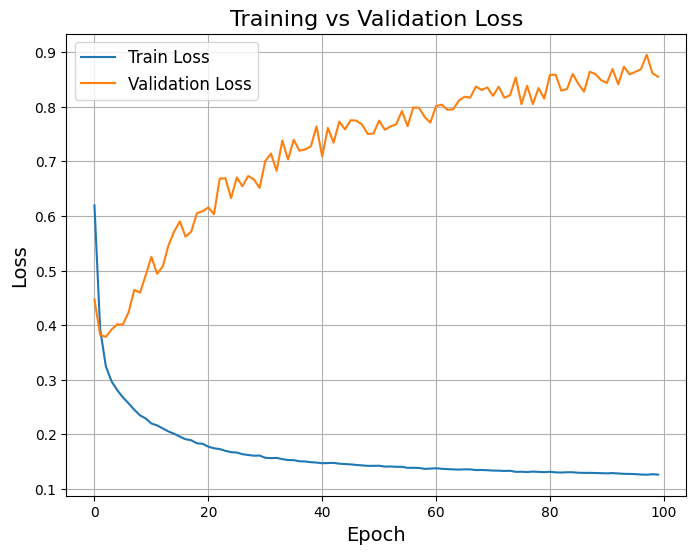

In [8]:
dfx = df.drop(columns = ['time_per_call', 'n_calls', 'normalized_time_per_call', 'convergence'] + elements).astype('float')
dfy = df['normalized_time_per_call'].astype('float')
# dfx.arch = 10
model = ann.TimePerCall(activation='swish', l1=1e-5,
             l2=1e-4, loss='mae', nvars = len(dfx.columns))
ind_tr, ind_val = ann.train_test_indices(dfx)
X_tr = dfx.loc[ind_tr]
Y_tr = dfy.loc[ind_tr]
X_val = dfx.loc[ind_val]
Y_val = dfy.loc[ind_val]
model.train_normed(X_tr, Y_tr, epochs=100, validation_split=0.2, plot=1, save_path="training_plotM100.png")

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step


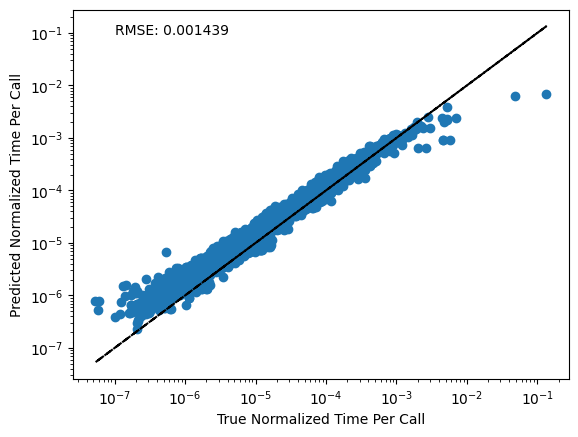

In [9]:
Y_hat = model.predict_normed(X_val)
plt.scatter(Y_val, Y_hat)
plt.plot(Y_val, Y_val, 'k--')
target = 'Normalized Time Per Call'
rmse = np.mean((Y_val.values - Y_hat[:, 0])**2)**0.5
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(1e-7, 0.7*max((Y_val)), "RMSE: %.6f" %(rmse))
plt.xscale('log')
plt.yscale('log')
plt.savefig("M100normalized_ann_prediction_hpc.png")
plt.show()

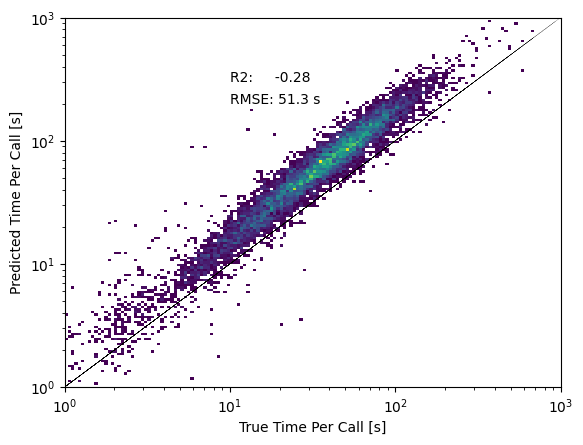

In [8]:
t_hat = Y_hat[:, 0] * X_val['n_el^3']*X_val['n_k']/X_val['n_cores']
t_val = df.loc[ind_val, 'time_per_call']
plt.plot(t_val, t_val, 'k--', lw=.1)
plt.hist2d(t_val, t_hat, bins = np.logspace(0, 3, 151), cmin = 0.01)
# plt.plot(t_val, 2*t_val, 'g-', lw=1)
target = 'Time Per Call [s]'
rmse = np.mean((t_val.values - t_hat)**2)**0.5
r2 = r2_score(t_val, t_hat)
plt.xlabel("True %s" %(target))
plt.ylabel("Predicted %s" %(target))
plt.text(10, 200, "RMSE: %.1f s" %(rmse))
plt.text(10, 300, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.savefig("M100ann_prediction_hpc.png")

In [56]:
model.save("model1")

INFO:tensorflow:Assets written to: model1/assets


In [57]:
import optimizer as opt

In [58]:
df_ = df.loc[df.arch  == 0]  # Use only data from Marconi
true_min, mean_time, time_with_pred_setup = [], [], []
pred_tpn, true_tpn, pred_np, true_np = [], [], [], []

for nel in df_.n_el.unique():
    for nn in df_.loc[df_.n_el == nel]['n_nodes'].unique():
        df__ = df_.loc[(df_.n_el == nel) & (df_.n_nodes == nn)]
        threads_per_node, nodes_per_pool = opt.optimize_from_df("optimizer.joblib", df__.iloc[0])
        n_pool = nn//nodes_per_pool
        true_min.append(df__['time_per_call'].min())
        mean_time.append(df__['time_per_call'].mean())
        minidx = df__['time_per_call'].idxmin()
        time_with_pred_setup.append(df__.loc[(df__.threads_per_node == threads_per_node) & (df__.n_pool == n_pool)]['time_per_call'].mean())
        true_np.append(df__.loc[minidx]['n_pool'])
        true_tpn.append(df__.loc[minidx]['threads_per_node'])
        pred_tpn.append(threads_per_node)
        pred_np.append(n_pool)
        
pred_tpn = np.array(pred_tpn)
pred_np = np.array(pred_np)
true_np = np.array(true_np)
true_min = np.array(true_min)
true_tpn = np.array(true_tpn)
mean_time = np.array(mean_time)
time_with_pred_setup = np.array(time_with_pred_setup)

<ipython-input-59-cea96f79dd43>:3: RuntimeWarning: invalid value encountered in greater
  rmse = np.mean((true_min[time_with_pred_setup>0] - time_with_pred_setup[time_with_pred_setup>0])**2)**0.5
<ipython-input-59-cea96f79dd43>:4: RuntimeWarning: invalid value encountered in greater
  r2 = r2_score(true_min[time_with_pred_setup>0], time_with_pred_setup[time_with_pred_setup>0])


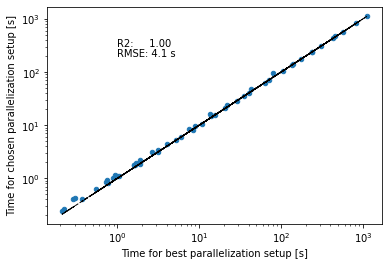

In [59]:
plt.scatter(true_min, time_with_pred_setup, s=20)
plt.plot(true_min, true_min, 'k--', lw=1)
rmse = np.mean((true_min[time_with_pred_setup>0] - time_with_pred_setup[time_with_pred_setup>0])**2)**0.5
r2 = r2_score(true_min[time_with_pred_setup>0], time_with_pred_setup[time_with_pred_setup>0])
plt.text(1, 200, "RMSE: %.1f s" %(rmse))
plt.text(1, 300, "R2:     %.2f" %(r2))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Time for best parallelization setup [s]")
plt.ylabel("Time for chosen parallelization setup [s]")
plt.savefig("../../plots/parallelization_optimization.png")

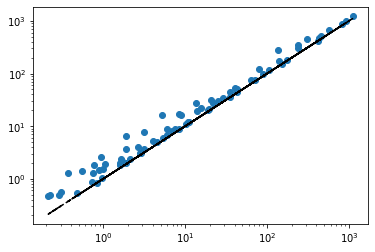

In [60]:
plt.scatter(true_min, mean_time)
plt.plot(true_min, true_min, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

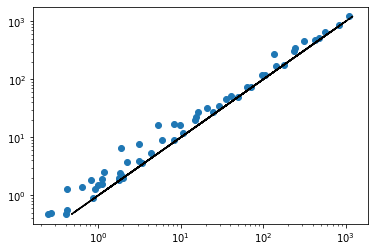

In [61]:
plt.scatter(time_with_pred_setup, mean_time)
plt.plot(mean_time, mean_time, 'k--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [28]:
df_ = df.loc[df.arch ==0].drop(columns = elements).drop(columns = ['convergence', 'n_transition', 'n_lanthanid', 'arch', 'n_el^3',
                                                                   'normalized_time_per_call', 'n_calls'])
tot = pd.DataFrame()
for nel in df_.n_el.unique():
    for nc in df_.loc[df_.n_el == nel]['n_cores'].unique():
        aa = df_.loc[(df_.n_el == nel) & (df_.n_cores == nc)]
        if len(aa) > 4:
            grouped = aa.groupby(by = ['threads_per_node', 'n_pool']).mean().reset_index()
            normfactor = grouped.time_per_call.min()
            grouped['norm_tpc'] = grouped.time_per_call/normfactor
            tot = tot.append(grouped.drop(columns = ['n_species', 'n_at', 'n_ks', 'time_per_call', 'n_g_smooth']))
            
tot['nodes_per_pool'] = tot.n_nodes/tot.n_pool
tot = tot.drop(columns = 'n_pool')

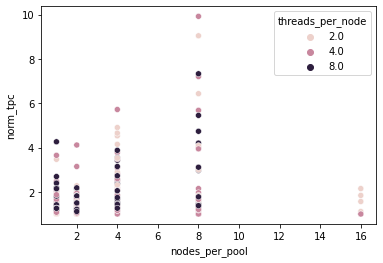

In [29]:
sns.scatterplot( data = tot, x = 'nodes_per_pool', hue = 'threads_per_node', y = 'norm_tpc', cmap = 'viridis')
plt.show()

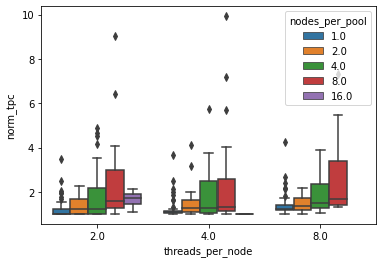

In [30]:
sns.boxplot( data = tot, x = 'threads_per_node', hue = 'nodes_per_pool', y = 'norm_tpc')
plt.show()

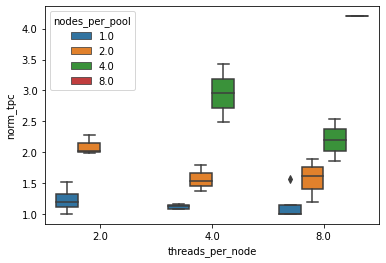

In [31]:
sns.boxplot( data = tot[tot.n_el == 80], x = 'threads_per_node', hue = 'nodes_per_pool', y = 'norm_tpc')
plt.show()

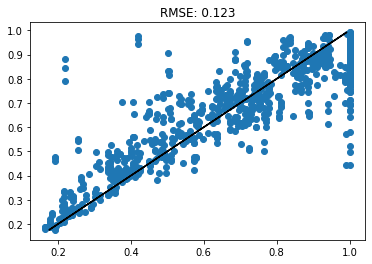

In [32]:
from sklearn.ensemble import RandomForestRegressor as rfr
import joblib

cross_vals = 10


def train_test_split(X, Y, split = 0.8):
    msk = np.random.rand(len(X)) < split
    return X[msk], Y[msk], X[~msk], Y[~msk]

df_ = df.loc[df.arch == 0].drop(columns = elements).drop(columns = ['convergence', 'n_transition', 'n_lanthanid', 'arch', 'n_el^3',
                                                                   'normalized_time_per_call', 'n_calls'])
tot = pd.DataFrame()
for nel in df_.n_el.unique():
    for nc in df_.loc[df_.n_el == nel]['n_cores'].unique():
        aa = df_.loc[(df_.n_el == nel) & (df_.n_cores == nc)]
        if len(aa) > 4:
            grouped = aa.groupby(by = ['threads_per_node', 'n_pool']).mean().reset_index()
            normfactor = grouped.time_per_call.min()
            grouped['norm_tpc'] = grouped.time_per_call/normfactor
            tot = tot.append(grouped.drop(columns = ['n_species', 'n_at', 'n_ks', 'time_per_call', 'n_g_smooth']))
            
tot['nodes_per_pool'] = tot.n_nodes/tot.n_pool
tot = tot.drop(columns = 'n_pool')
Y = np.exp(2/tot.norm_tpc.values)/np.e**2
X = np.log(tot.drop(columns = 'norm_tpc').values)
Y_vals, Y_hats = [], []
for r in np.arange(cross_vals):
    X_tr, Y_tr, X_val, Y_val = train_test_split(X, Y)
    regressor = rfr(min_samples_split=3).fit(X_tr, Y_tr)
    Y_hat = regressor.predict(X_val)
    Y_vals.extend(Y_val)
    Y_hats.extend(Y_hat)
Y_hats = np.array(Y_hats)
Y_vals = np.array(Y_vals)

joblib.dump(regressor, "./optimizer.joblib")


rmse = np.mean((Y_hats - Y_vals)**2)**0.5
plt.scatter(Y_vals, Y_hats)
plt.plot(Y_hats, Y_hats, 'k-')
plt.title("RMSE: %.3f" %(rmse))
plt.show()